In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,confusion_matrix
import tensorflow_hub as tfhub
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.express as px
import seaborn as sns
import numpy.matlib as nm
import numpy.fft as f
from PIL import Image
from tqdm import tqdm
import sys
import argparse
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from PIL import Image
import re
import multiprocessing as mp
import math as mt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import files

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d utkarshsaxenadn/landscape-recognition-image-dataset-12k-images

 95% 473M/496M [00:02<00:00, 194MB/s]
100% 496M/496M [00:02<00:00, 176MB/s]


In [ ]:
! mkdir train1

In [ ]:
! unzip landscape-recognition-image-dataset-12k-images.zip -d train1

Streaming output truncated to the last 5000 lines.
  inflating: train1/Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1449).jpeg  
  inflating: train1/Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (145).jpeg  
  inflating: train1/Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1450).jpeg  
  inflating: train1/Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1451).jpeg  
  inflating: train1/Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1452).jpeg  
  inflating: train1/Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1453).jpeg  
  inflating: train1/Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1454).jpeg  
  inflating: train1/Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (145

# Part 1: Data Exploration and Preprocessing

Loading dataset

In [ ]:
TRAIN_DIR = '/content/train1/Landscape Classification/Landscape Classification/Training Data'

In [ ]:
VALID_DIR = '/content/train1/Landscape Classification/Landscape Classification/Validation Data'

In [ ]:
TEST_DIR = '/content/train1/Landscape Classification/Landscape Classification/Testing Data'

In [ ]:
class_names = sorted(os.listdir(TRAIN_DIR))
n_classes = len(class_names)

print(f"Number of Classes : {n_classes}\nClass names : {class_names}")

Number of Classes : 5
Class names : ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


Visualizing the train , test and validation dataset

In [ ]:
class_dis = [len(os.listdir(TRAIN_DIR +"/"+ name)) for name in class_names]


# Visualize
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()


In [ ]:
class_dis = [len(os.listdir(VALID_DIR +"/" +name)) for name in class_names]


# Visualize
fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [ ]:
class_dis = [len(os.listdir(TEST_DIR + "/"+name)) for name in class_names]


# Visualize
fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

Extracting paths and labels of every image

In [ ]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


In [ ]:
# function that contain the three directory of data train, valid, and test
def split_data(tr_dir, val_dir, ts_dir):
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [ ]:
def show_images(df,num_of_images):
    sample = min(len(df), num_of_images)
    images = []
    labels=[]
    index=[i for i in range(len(df))]
    sz=int(mt.sqrt(sample))
    random.shuffle(index)
    for i in range(sample):
      labels.append(df['labels'][index[i]])
      images.append(cv2.cvtColor(cv2.imread(df['filepaths'][index[i]]),cv2.COLOR_BGR2RGB))
    plt.figure(figsize= (20, 20))
    for i in range(sample):
        plt.subplot(sz, sz, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        class_name = labels[i]
        plt.title(class_name, fontsize= 12)
        plt.axis('off')
    plt.show()

In [ ]:
train_df, valid_df, test_df = split_data(TRAIN_DIR, VALID_DIR, TEST_DIR)

Visualizing some of the images

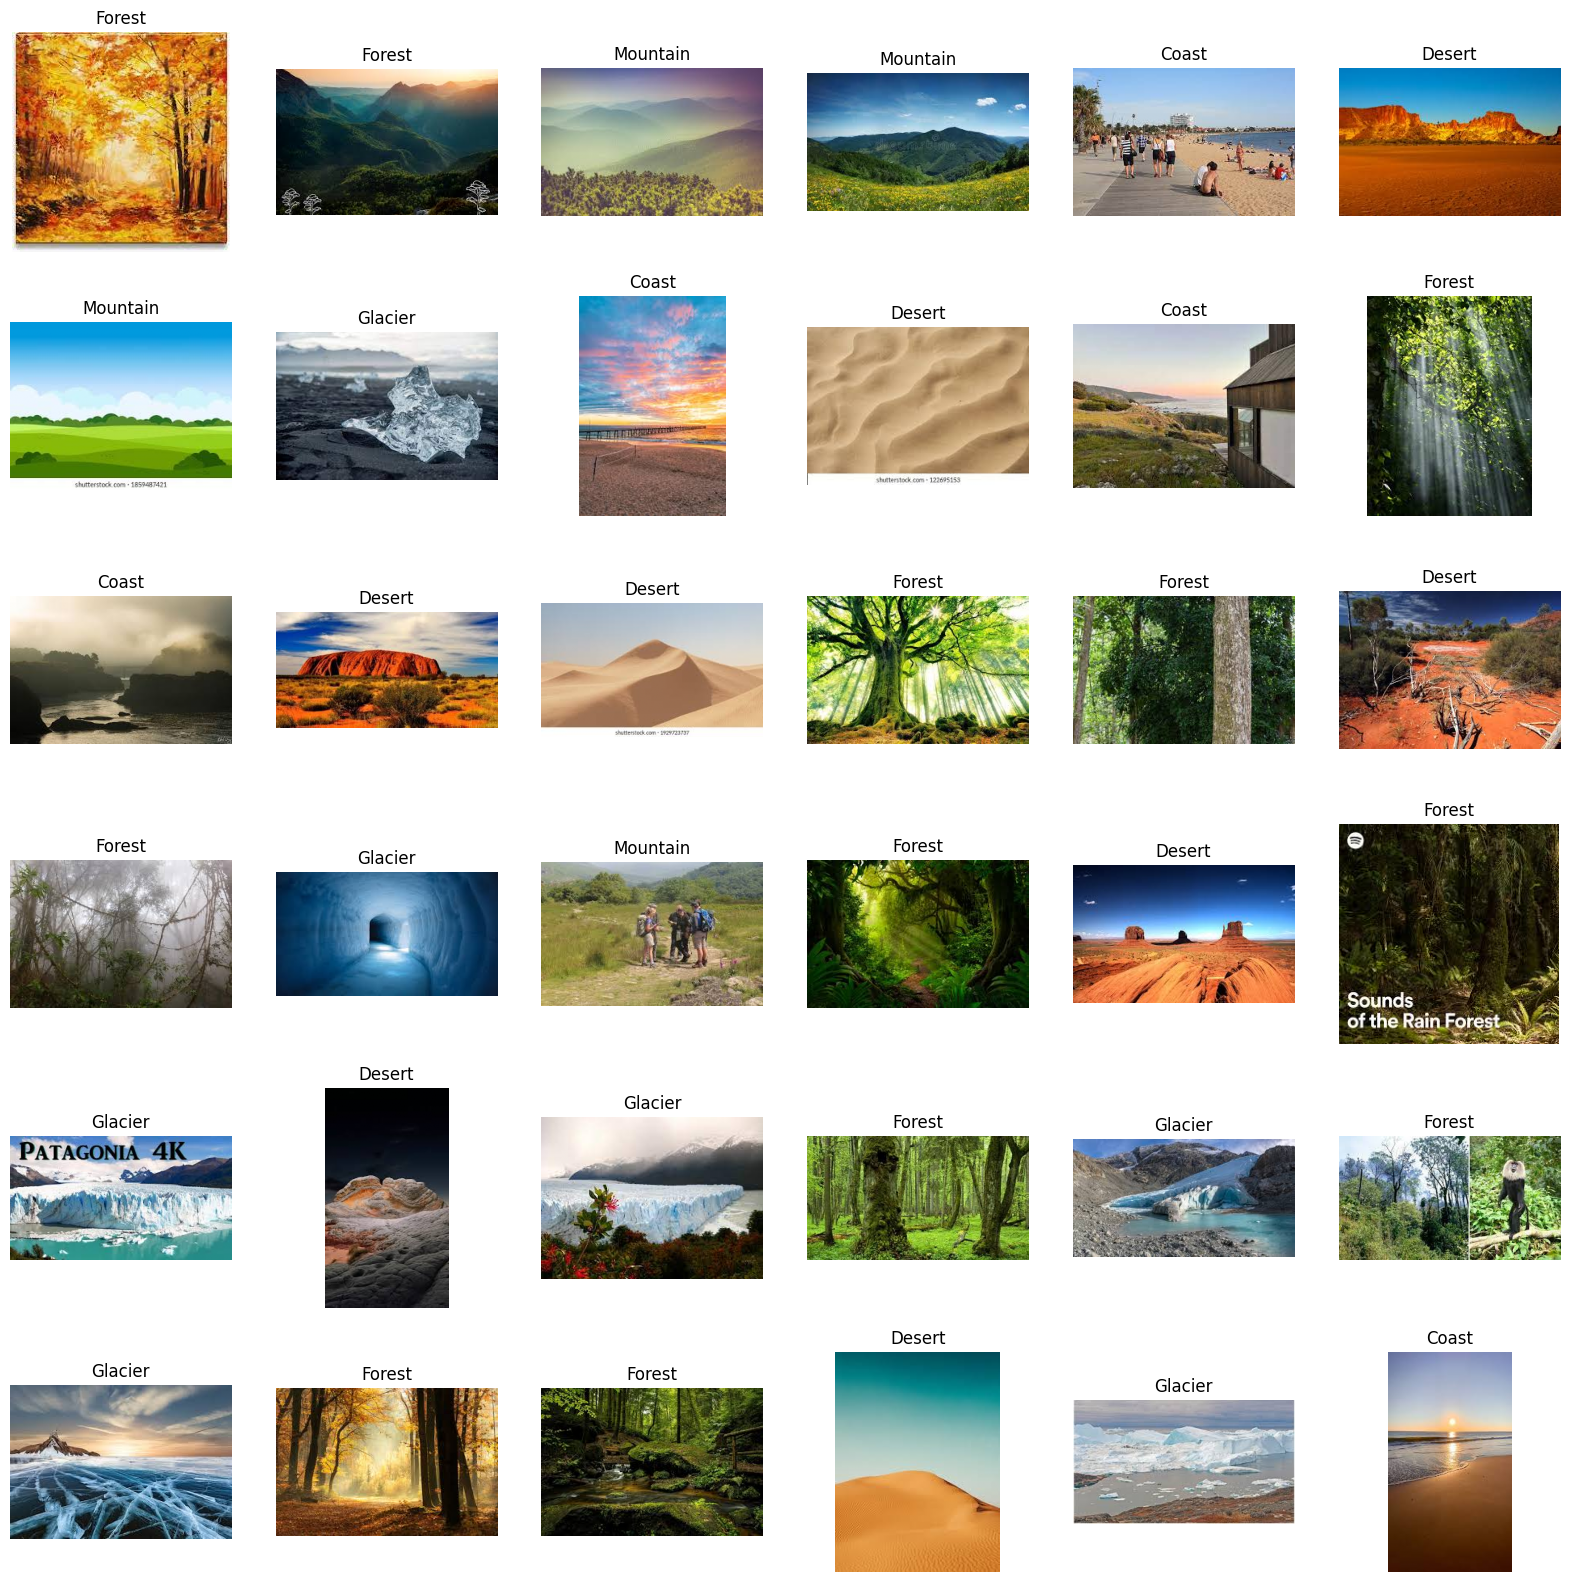

In [ ]:
show_images(train_df,36)

GIST feature exactraction

In [ ]:
class GIST():
    def __init__(self,param):
        self.param = param

    def _createGabor(self,orr,n):

        gabor_param = []
        Nscalse = len(orr)
        Nfilters = sum(orr)
        if len(n) == 1:
            n = [n[0],n[0]]
        for i in range(Nscalse):
            for j in range(orr[i]):
                gabor_param.append([.35,.3/(1.85**(i)),16*orr[i]**2/32**2, np.pi/(orr[i])*(j)])
        gabor_param = np.array(gabor_param)
        fx, fy = np.meshgrid(np.arange(-n[1]/2,n[1]/2-1 + 1), np.arange(-n[0]/2, n[0]/2-1 + 1))
        fr = f.fftshift(np.sqrt(fx**2+fy**2))
        t = f.fftshift(np.angle(fx+ 1j*fy))

        G = np.zeros([n[0],n[1],Nfilters])
        for i in range(Nfilters):
            tr = t + gabor_param[i,3]
            tr+= 2*np.pi*(tr < -np.pi) - 2 * np.pi*(tr>np.pi)
            G[:,:,i] = np.exp(-10*gabor_param[i,0]*(fr/n[1]/gabor_param[i,1]-1)**2-2*gabor_param[i,2]*np.pi*tr**2)

        return G

    def _more_config(self,img):

        self.param["imageSize"] = [img.shape[0], img.shape[1]]
        self.param["G"] = self._createGabor(self.param["orientationsPerScale"],np.array(self.param["imageSize"])+2*self.param["boundaryExtension"])


    def _preprocess(self,img):
        M = self.param["imageSize"]
        if len(M) == 1:
            M = [M, M]
        scale = np.max([M[0]/img.shape[0], M[1]/img.shape[1]])
        newsize = list(map(int,np.round(np.array([img.shape[1],img.shape[0]]) * scale)))
        img = np.array(Image.fromarray(img).resize(newsize, Image.BILINEAR))
        #img = imresize(img,newsize,'bilinear')

        nr,nc = img.shape
        sr = (nr-M[0])/2
        sc = (nc-M[1])/2

        img = img[int(sr):int(sr+M[0])+ 1,int(sc):int(sc+M[1])+1]
        img = img- np.min(img)
        if np.sum(img) != 0:
            img = 255*(img/np.max(img))

        return img


    def _prefilt(self,img):

        w = 5
        fc=self.param["fc_prefilt"]
        s1 = fc/np.sqrt(np.log(2))
        img=np.log(img +1 )
        img = np.pad(img,[w,w],"symmetric")

        sn,sm = img.shape
        n = np.max([sn,sm])
        n += n%2

        if sn == sm:
            img = np.pad(img,[0,int(n-sn)],"symmetric")
        elif sn < sm:
            img = np.pad(img,[0,int(n-sn)], "symmetric")[:,:sm + (1 if sm % 2 != 0 else 0)]
        else:
            img = np.pad(img, [0, int(n - sm)], "symmetric")[sn - sm:]

        fx,fy = np.meshgrid(np.arange(-n/2,n/2-1 + 1),np.arange(-n/2,n/2-1 + 1))
        gf = f.fftshift((np.exp(-(fx**2+fy**2)/(s1**2))))
        gf = nm.repmat(gf,1,1)
        output = img - np.real(f.ifft2(f.fft2(img)*gf))

        localstd = nm.repmat(np.sqrt(abs(f.ifft2(f.fft2(output**2)*gf))), 1 ,1 )
        output = output/(0.2+localstd)
        output = output[w:sn-w, w:sm-w]
        return output

    def _gistGabor(self,img):

        w = self.param["numberBlocks"]
        G = self.param["G"]
        be = self.param["boundaryExtension"]
        ny,nx,Nfilters = G.shape
        W = w[0] * w[1]
        N = 1
        g = np.zeros((W*Nfilters, N))
        img = np.pad(img,[be,be],"symmetric")
        img = f.fft2(img)

        k = 0
        for n in range(Nfilters):
            ig = abs(f.ifft2(img*nm.repmat(G[:,:,n],1,1)))
            ig = ig[be:ny-be,be:nx-be]
            v = self._downN(ig,w)
            g[k:k+W,0] = v.reshape([W,N],order = "F").flatten()
            k += W
        return np.array(g)

    def _downN(self,x,N):
        nx = list(map(int,np.floor(np.linspace(0,x.shape[0],N[0]+1))))
        ny = list(map(int,np.floor(np.linspace(0,x.shape[1 ],N[1]+1))))
        y  = np.zeros((N[0],N[1]))
        for xx in range(N[0]):
            for yy in range(N[1]):
                a = x[nx[xx]:nx[xx+1], ny[yy]:ny[yy+1]]
                v = np.mean(np.mean(a,0))
                y[xx,yy]=v
        return y

    def _gist_extract(self,img):

        self._more_config(img)

        img = self._preprocess(img)

        output = self._prefilt(img)

        gist = self._gistGabor(output)

        return gist.flatten()


In [ ]:
param = {
        "orientationsPerScale":np.array([5,5]),
         "numberBlocks":[5,5],
        "fc_prefilt":10,
        "boundaryExtension":32
}
class Dataloader():
	def __init__(self,input_path, output_path):
		self.input_path = input_path
		self.output_path = output_path
		self.is_dir = 0 if re.search("\.",input_path) != None else 1

	def get_inputfile(self) -> list:
		if self.is_dir:
			# dirctory in images
			path = f"{self.input_path}/"
			a = sorted(os.listdir(path))
			file_list = list(map(lambda x: path + x, a))

			return file_list
		else:
			# image file such png, jpg etc..
			path = f"{self.input_path}"
			return [path]
	def save_feature(self,x:np.array):
		if self.is_dir:
			gist_df = pd.DataFrame(x, columns = [f"gist_{i}" for i in range(x.shape[1])])
		else:
			gist_df = pd.DataFrame(x.reshape(1,-1), columns = [f"gist_{i}" for i in range(x.shape[1])])

		gist_df.to_feather(f"./{self.output_path}")

def _get_gist(param:dict,file_list:list) -> np.array:
	img_list = list(map(lambda f :np.array(Image.open(f).convert("L")), file_list))
	gist = GIST(param)

	with mp.Pool(mp.cpu_count()) as pool:
		p = pool.imap(gist._gist_extract,img_list[:])
		gist_feature = list(tqdm(p, total = len(img_list)))
	return np.array(gist_feature)


gist_feature = _get_gist(param,train_df['filepaths'])
print(gist_feature.shape)


100%|██████████| 10000/10000 [26:28<00:00,  6.30it/s]


(10000, 250)


Quantization of gist features

In [ ]:
def quantize_features(features, num_states=5):
    quantized_features = np.digitize(features, np.linspace(0, features.max(), num_states))
    return quantized_features

In [ ]:
gist_feature_train=gist_feature
qt_features_train = quantize_features(gist_feature_train)

In [ ]:
train_data = pd.DataFrame(qt_features_train, columns = [str(i) for i in range(len(gist_feature[0]))])
train_data=pd.concat([train_data,train_df['labels']],axis=1)
train_data

0  1  2  3  4  5  6  7  8  9  ...  241  242  243  244  245  246  247  \
0     1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    2   
1     1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    1   
2     1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    1   
3     1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    1   
4     1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    1   
...  .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
9995  1  1  1  1  1  1  1  1  1  1  ...    1    1    2    1    1    1    1   
9996  2  2  2  2  2  1  1  2  2  2  ...    1    1    2    2    1    1    1   
9997  2  2  1  1  1  2  2  1  2  1  ...    1    1    1    1    1    1    1   
9998  2  2  2  2  2  2  2  2  2  2  ...    2    2    2    2    2    2    2   
9999  2  2  2  2  1  1  1  2  2  2  ...    2    2    2    1    1    2    2   

      248  249  labels  
0       1    1   Coast  
1       1    1   Coast  
2       1    1   Coast  
3       1    1   Coast  
4       1    1   Coast  
...   ...  ...     ...  
9995    1    1  Forest  
9996    2    2  Forest  
9997    1    1  Forest  
9998    1    2  Forest  
9999    2    2  Forest  

[10000 rows x 251 columns]

In [ ]:
x_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]

In [ ]:
y_train

0        Coast
1        Coast
2        Coast
3        Coast
4        Coast
         ...  
9995    Forest
9996    Forest
9997    Forest
9998    Forest
9999    Forest
Name: labels, Length: 10000, dtype: object

# Part 2: Bayesian Network Classifier

In [ ]:
class BayesianNetworkClassifier:
    def __init__(self):
        self.class_prior = {}
        self.feature_likelihoods = {}
        self.X_train=np.array
        self.unique_classes = []
        self.posterior_probability=[]

    def fit(self, X, y):

        self.unique_classes = np.unique(y)
        total_samples = len(y)
        class_counts = [0]*len(self.unique_classes)
        class_counts=np.array(class_counts)
        classes, counts = np.unique(y, return_counts=True)
        # for class_label, count in zip(classes, counts):
        #     self.class_prior[class_label] = count / total_samples
        for i in range(len(self.unique_classes)):
            class_counts[i] = np.sum(y == self.unique_classes[i])
            self.class_prior[self.unique_classes[i]] = class_counts[i] / total_samples
        # print(class_counts)
        for feature in range(X.shape[1]):
            self.feature_likelihoods[feature] = {}
            unique_feature_values = np.unique(X[:, feature])
            for cls in self.unique_classes:
                self.feature_likelihoods[feature][cls] = {}
                count_c = class_counts[self.unique_classes == cls][0]
                # print(class_counts[self.unique_classes == cls])
                for value in unique_feature_values:
                    l=(X[:, feature] == value) & (y == cls)
                    count_x_given_c = np.sum(l)
                    self.feature_likelihoods[feature][cls][value] = count_x_given_c / count_c

    def _calc_predictor_prior(self):
      for feature in self.features:
        feat_vals = self.X_train[feature].value_counts().to_dict()
        for feat_val, count in feat_vals.items():
          self.pred_priors[feature][feat_val] = count/self.train_size


    def predict(self, X):
        predictions = []
        for sample in X:
            class_scores = {}
            for cls in self.unique_classes:
                prior = self.class_prior[cls]
                likelihood = 1.0
                for feature, value in enumerate(sample):
                    if value in self.feature_likelihoods[feature][cls]:
                        likelihood *= self.feature_likelihoods[feature][cls][value]
                class_scores[cls] = prior * likelihood
            self.posterior_probability.append(class_scores)
            predictions.append(max(class_scores, key= lambda x: class_scores[x]))
        return predictions

#Part 3: Training the Bayesian network - Parameter estimation

In [ ]:
classifier = BayesianNetworkClassifier()
classifier.fit(x_train.values, y_train)

In [ ]:
y_train_pred = classifier.predict(x_train.values)
accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nTraining Accuracy: {accuracy*100}")


Training Accuracy: 42.71


In [ ]:
gist_feature_test=_get_gist(param,test_df['filepaths'])

100%|██████████| 500/500 [01:19<00:00,  6.27it/s]


In [ ]:
qt_features_test= quantize_features(gist_feature_test)

In [ ]:
test_data= pd.DataFrame(qt_features_test, columns = [str(i) for i in range(len(gist_feature[0]))])
test_data=pd.concat([test_data,test_df['labels']],axis=1)
test_data

0  1  2  3  4  5  6  7  8  9  ...  241  242  243  244  245  246  247  \
0    1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    2    1   
1    1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    1   
2    2  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    1   
3    1  1  2  1  1  1  2  2  1  1  ...    1    1    1    1    1    1    1   
4    2  1  1  1  1  2  1  1  1  1  ...    1    1    1    1    1    1    1   
..  .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
495  2  2  2  2  2  2  2  2  2  2  ...    2    1    1    1    2    2    2   
496  2  2  1  2  1  2  2  1  1  1  ...    1    1    1    1    2    2    1   
497  2  2  2  2  2  2  1  2  2  2  ...    2    2    2    2    2    2    2   
498  3  3  3  2  2  2  3  2  2  2  ...    2    2    2    2    1    1    2   
499  2  2  2  2  2  2  2  2  2  2  ...    1    1    2    2    2    2    2   

     248  249  labels  
0      1    1   Coast  
1      1    1   Coast  
2      1    1   Coast  
3      1    1   Coast  
4      1    1   Coast  
..   ...  ...     ...  
495    1    1  Forest  
496    2    1  Forest  
497    2    2  Forest  
498    2    2  Forest  
499    2    2  Forest  

[500 rows x 251 columns]

In [ ]:
x_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

In [ ]:
x_test

0  1  2  3  4  5  6  7  8  9  ...  240  241  242  243  244  245  246  \
0    1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    2   
1    1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    1   
2    2  1  1  1  1  1  1  1  1  1  ...    1    1    1    1    1    1    1   
3    1  1  2  1  1  1  2  2  1  1  ...    1    1    1    1    1    1    1   
4    2  1  1  1  1  2  1  1  1  1  ...    1    1    1    1    1    1    1   
..  .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
495  2  2  2  2  2  2  2  2  2  2  ...    2    2    1    1    1    2    2   
496  2  2  1  2  1  2  2  1  1  1  ...    2    1    1    1    1    2    2   
497  2  2  2  2  2  2  1  2  2  2  ...    2    2    2    2    2    2    2   
498  3  3  3  2  2  2  3  2  2  2  ...    1    2    2    2    2    1    1   
499  2  2  2  2  2  2  2  2  2  2  ...    2    1    1    2    2    2    2   

     247  248  249  
0      1    1    1  
1      1    1    1  
2      1    1    1  
3      1    1    1  
4      1    1    1  
..   ...  ...  ...  
495    2    1    1  
496    1    2    1  
497    2    2    2  
498    2    2    2  
499    2    2    2  

[500 rows x 250 columns]

In [ ]:
y_test

0       Coast
1       Coast
2       Coast
3       Coast
4       Coast
        ...  
495    Forest
496    Forest
497    Forest
498    Forest
499    Forest
Name: labels, Length: 500, dtype: object

In [ ]:
predictions = classifier.predict(x_test.values)
accuracy = accuracy_score(y_test, predictions)

In [ ]:
print(f"\nTesting Accuracy: {accuracy*100}")


Testing Accuracy: 53.800000000000004


#Part 4: Evaluation and Interpretation

Calculate accuracy, precision, recall, and F1-score for each
individual class

In [ ]:
f1_scores_test=f1_score(y_test, predictions, average=None)
print("f1_score on testing data" ,f1_scores_test)
f1_scores_train=f1_score(y_train, y_train_pred, average=None)
print("f1_score on training data" ,f1_scores_train)

f1_score on testing data [0.3373494  0.52589641 0.68       0.20833333 0.4021164 ]
f1_score on training data [0.2398682  0.48190414 0.72261307 0.22520458 0.34088514]


In [ ]:
precision_scores_test=precision_score(y_test, predictions, average=None)
print("precision_scores on testing data" ,precision_scores_test)
precision_scores_train=precision_score(y_train, y_train_pred, average=None)
print("precision_scores on training data" ,precision_scores_train)

precision_scores on testing data [0.42424242 0.43708609 0.56666667 0.34090909 0.42696629]
precision_scores on training data [0.35169082 0.35752298 0.72626263 0.32606635 0.36024499]


In [ ]:
recall_scores_test=recall_score(y_test, predictions, average=None)
print("recall_scores on testing data" ,recall_scores_test)
recall_scores_train=recall_score(y_train, y_train_pred, average=None)
print("recall_scores on training data" ,recall_scores_train)

recall_scores on testing data [0.28 0.66 0.85 0.15 0.38]
recall_scores on training data [0.182  0.739  0.719  0.172  0.3235]


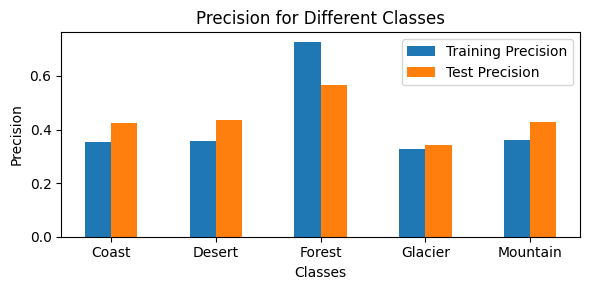

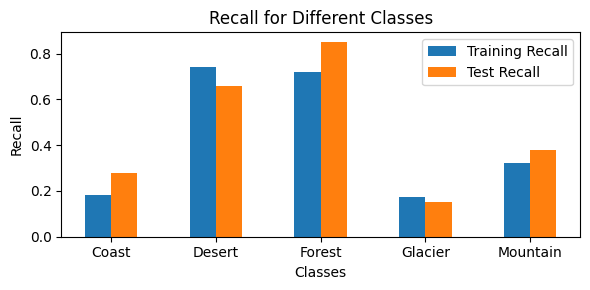

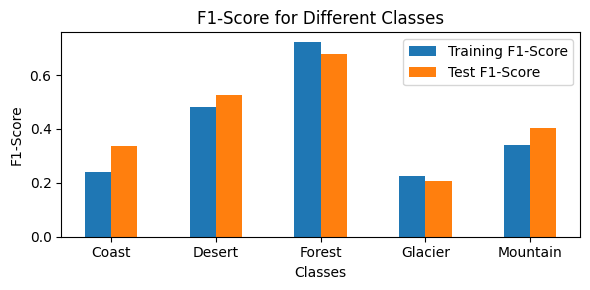

In [ ]:
def plot(test_data,train_data,matrix):
  class_indices = range(len(class_names))
  fig, ax = plt.subplots(figsize=(6, 3))
  bar_width = 0.25
  train_bars = []
  test_bars = []
  for i in class_indices:
    train_bars.append(i - bar_width/2 )
    test_bars.append(i + bar_width/2)
  plt.bar(train_bars, train_data, bar_width, label='Training'+' '+matrix)
  plt.bar(test_bars, test_data, bar_width, label='Test'+' '+matrix)
  plt.xlabel('Classes')
  plt.xticks(class_indices, class_names)
  plt.title(matrix+ ' '+ 'for Different Classes')
  plt.ylabel(matrix)
  plt.legend()
  plt.tight_layout()
  plt.show()

plot(precision_scores_test,precision_scores_train,'Precision')
plot(recall_scores_test,recall_scores_train,'Recall')
plot(f1_scores_test,f1_scores_train,'F1-Score')

Generate the confusion matrix using the training and the test sets.
Visualize it as a heatmap for better interpretation.

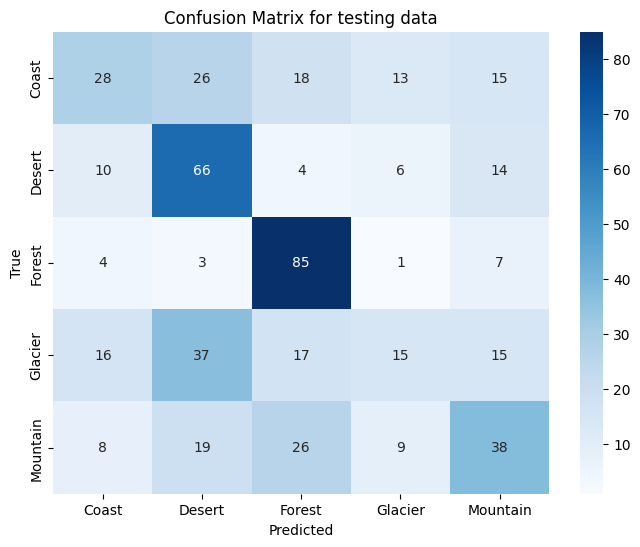

In [ ]:
confusion_mat = confusion_matrix(y_test,predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for testing data")
plt.show()

Conduct feature importance analysis to identify which specific
features contribute the most to the classification decisions.

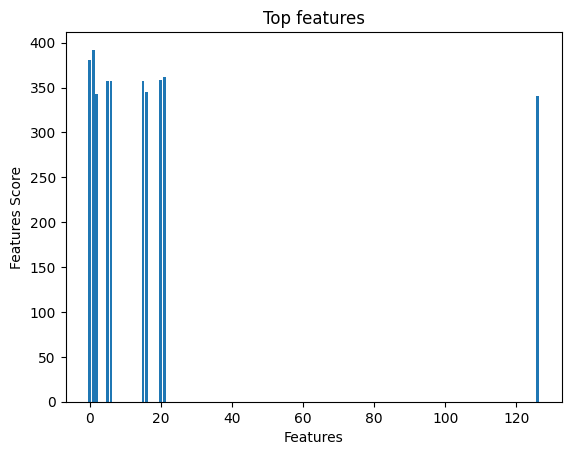

Best Feature is at index 1 with score: 392.2132725430709


In [ ]:
k_best = SelectKBest(chi2, k='all')
k_best.fit(x_train, y_train)
feature_scores = k_best.scores_

sorted_indices = np.argsort(feature_scores)[::-1]
top_ten_features=[sorted_indices[i] for i in range(10)]
top_ten_feature_score=[feature_scores[i] for i in top_ten_features]
plt.bar(top_ten_features, top_ten_feature_score)
plt.xlabel('Features')
plt.ylabel('Features Score')
plt.title('Top features')
plt.show()
print(f"Best Feature is at index {sorted_indices[0]} with score: {feature_scores[sorted_indices[0]]}")


Randomly select a subset of test images and visualize the model's
predictions along with the ground truth labels.

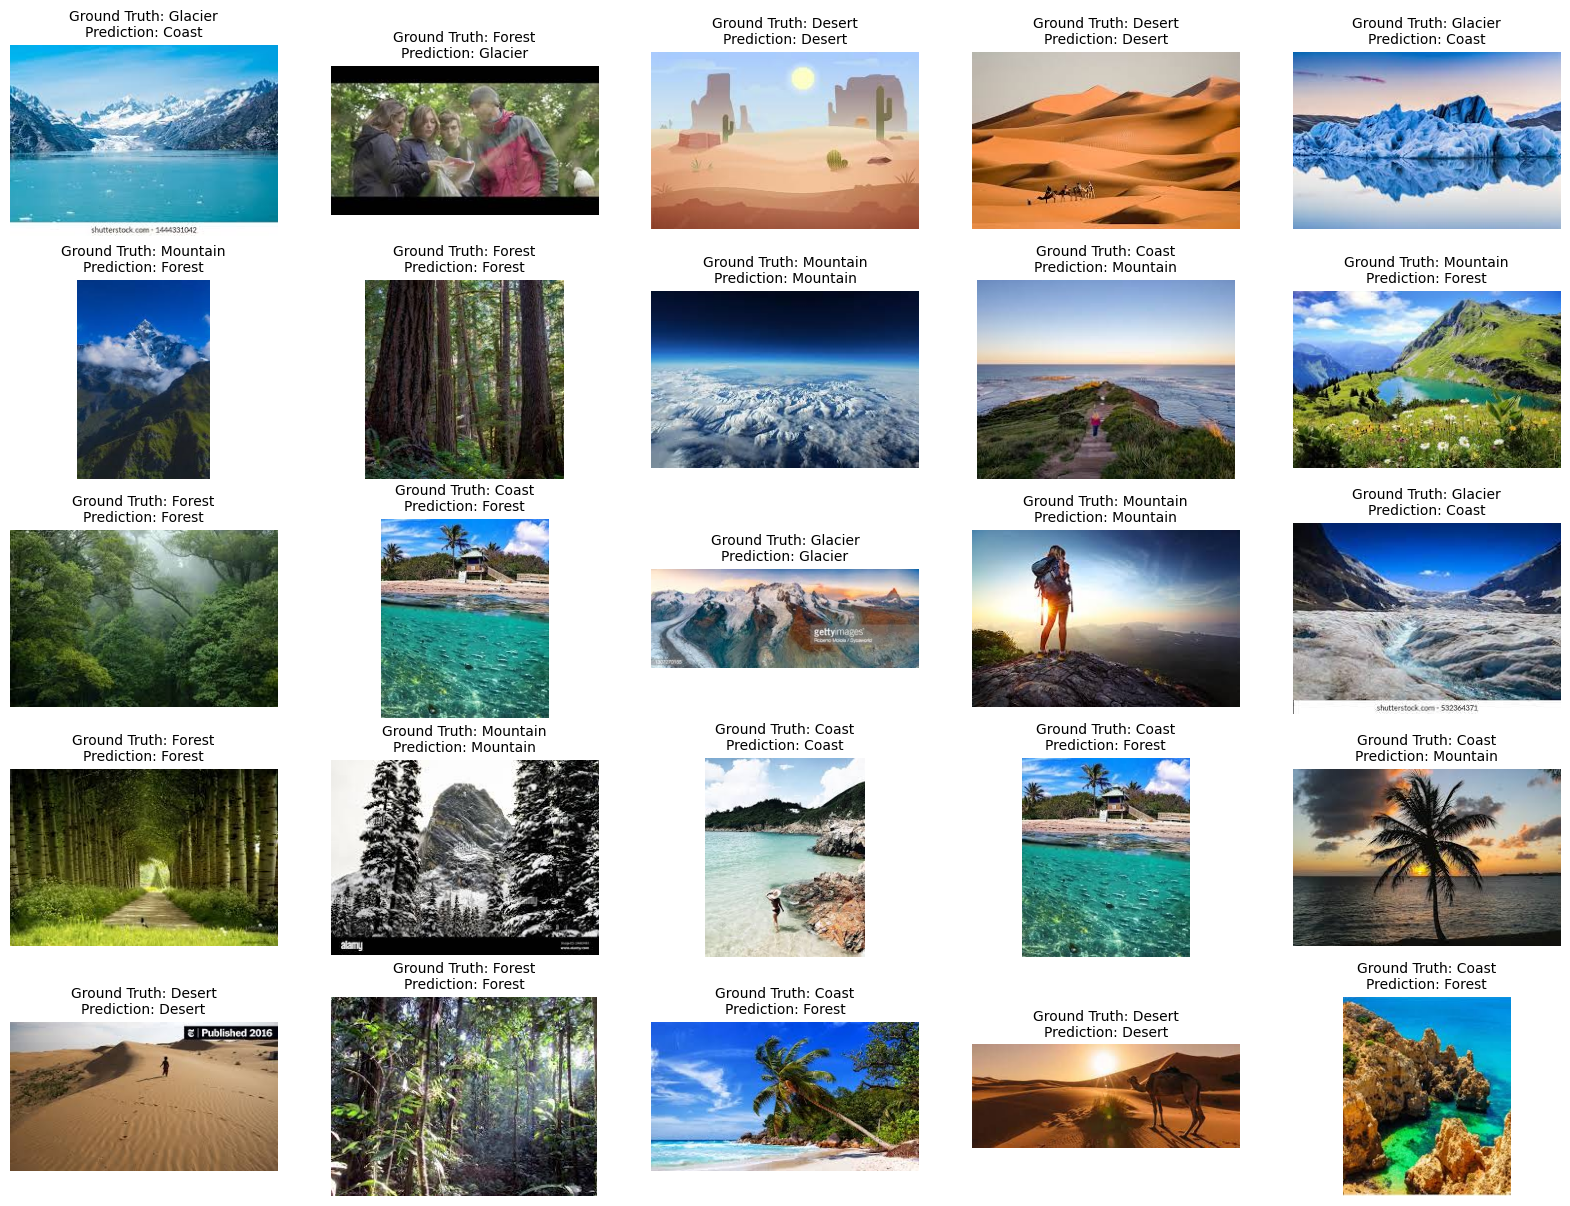

In [ ]:
num_images = 25
subset=[]
for i in range(25):
  subset.append(random.randrange(500))
plt.figure(figsize=(20, 15))

for i, index in enumerate(subset):
    plt.subplot(5, 5, i + 1)
    # print(test_df['filepaths'][index])
    plt.imshow(cv2.cvtColor(cv2.imread(test_df['filepaths'][index]),cv2.COLOR_BGR2RGB))
    # print(y_test[index])
    plt.title(f"Ground Truth: {y_test[index]}\nPrediction: {predictions[index]}", fontsize=10)
    plt.axis('off')

plt.show()

Show the posterior probability values for the class to which the image is
classified, and the class and the posterior probability for which the
posterior probability is the second highest.

In [ ]:
# Printing post prob
post_prob=classifier.posterior_probability
for i in subset:
  items = list(post_prob[i].items())
  items.sort(key=lambda x: x[1], reverse=True)
  highest_key, highest_value = items[0]
  second_highest_key, second_highest_value = items[1]
  print(f'Predicted class is: {highest_key} - with posterior probability {highest_value}')
  print(f'Class with second highest posterior probability is: {second_highest_key} - with posterior probability {second_highest_value}')
  print()



Predicted class is: Coast - with posterior probability 7.893253086385026e-40
Class with second highest posterior probability is: Mountain - with posterior probability 4.5181919193438033e-41

Predicted class is: Glacier - with posterior probability 1.35923112133526e-19
Class with second highest posterior probability is: Desert - with posterior probability 4.0854898383981506e-20

Predicted class is: Desert - with posterior probability 3.9079115607215115e-09
Class with second highest posterior probability is: Glacier - with posterior probability 3.163792638426322e-10

Predicted class is: Desert - with posterior probability 8.30248870045118e-11
Class with second highest posterior probability is: Glacier - with posterior probability 1.0021054881986274e-11

Predicted class is: Coast - with posterior probability 2.5338073391681963e-35
Class with second highest posterior probability is: Mountain - with posterior probability 1.3984486728287903e-36

Predicted class is: Forest - with posterior pr